In [ ]:
import pandas as pd
import numpy_financial as npf
import matplotlib.pyplot as plt
import re
import sys
from sqlalchemy import create_engine, text

# --- COMPATIBILITY IMPORTS (Safe for OpenWebUI) ---
from langchain_community.llms import Ollama 
from langchain_community.utilities import SQLDatabase

# FIX: Robust imports for Tool and Agents
# Try standard locations first, then fallbacks
try:
    from langchain.agents import Tool, AgentExecutor, create_react_agent
except ImportError:
    try:
        # Newer LangChain structure
        from langchain_core.tools import Tool
        from langchain.agents import AgentExecutor, create_react_agent
    except ImportError:
        # Fallback for older/mixed environments
        from langchain.tools import Tool
        from langchain.agents import AgentExecutor, create_react_agent

from langchain import hub

# --- JUPYTER SUPPORT ---
try:
    from IPython.display import display, Image
    IN_JUPYTER = True
except ImportError:
    IN_JUPYTER = False

# --- 1. CONFIGURATION ---
DB_USER = "postgres"
DB_PASS = "postgres" 
DB_HOST = "127.0.0.1"
DB_PORT = "5432"
DB_NAME = "private_markets_db"

# DEEPSEEK CONFIG
LLM_MODEL = "deepseek-r1:70b"
LLM_BASE_URL = "http://localhost:21434"

# Connect to Database
try:
    connection_str = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(connection_str)
    db = SQLDatabase(engine)
    print(f"✅ Database Connected (User: {DB_USER})")
except Exception as e:
    print(f"❌ Database Error: {e}")
    sys.exit(1)

# --- 2. INITIALIZE LEGACY LLM ---
llm = Ollama(
    model=LLM_MODEL,
    base_url=LLM_BASE_URL,
    temperature=0.0,
    num_ctx=8192
)

# --- 3. ROBUST HELPER FUNCTIONS ---

def clean_llm_output(text: str) -> str:
    """
    Cleans DeepSeek-R1 output to prevent SQL Syntax Errors.
    Removes <think> tags and markdown code blocks.
    """
    if "</think>" in text:
        text = text.split("</think>")[-1]
    
    code_match = re.search(r"```sql\n(.*?)\n```", text, re.DOTALL)
    if code_match:
        return code_match.group(1).strip()
    
    code_match_generic = re.search(r"```\n(.*?)\n```", text, re.DOTALL)
    if code_match_generic:
        return code_match_generic.group(1).strip()
        
    text = text.replace("```sql", "").replace("```", "").strip()
    return text

# --- 4. TOOLS ---

def robust_sql_query(query_input: str):
    """
    Generates and executes SQL safely with strict logic for duplicates.
    """
    prompt = f"""
    You are a PostgreSQL expert. Given the user question, write a valid SQL query.
    
    ### DATABASE SCHEMA (STRICTLY FOLLOW THESE TABLE NAMES):
    1. Table: pe_portfolio (alias: p)
       - Columns: fund_id (PK), fund_name, vintage_year, 
                  primary_strategy (e.g., 'Private Equity', 'Venture Capital'), 
                  sub_strategy (e.g., 'Leveraged Buyout (LBO)', 'Growth Equity'), 
                  total_commitment_usd
    2. Table: pe_historical_cash_flows (alias: cf)
       - Columns: transaction_id, fund_id (FK), transaction_date, transaction_type, 
                  investment_paid_in_usd (negative), management_fees_usd (negative),
                  return_of_cost_distribution_usd (positive), profit_distribution_usd (positive),
                  net_asset_value_usd (NAV)

    ### CALCULATION RULES:
    1. Paid In = investment_paid_in_usd + management_fees_usd (Negative)
    2. Distributions = profit_distribution_usd + return_of_cost_distribution_usd (Positive)
    3. TVPI = (SUM(Distributions) + SUM(Latest_NAV)) / ABS(SUM(Paid_In))
    4. **MANAGEMENT FEES:** To find "Total Management Fees", SUM(management_fees_usd). The result will be negative; display as ABS().
    5. **LATEST NAV LOGIC (CRITICAL):**
       - Duplicate rows exist for the same date. Do NOT use a simple MAX(date).
       - Use this CTE pattern to pick the single latest row per fund:
         WITH ordered_navs AS (
             SELECT fund_id, net_asset_value_usd,
             ROW_NUMBER() OVER (PARTITION BY fund_id ORDER BY transaction_date DESC, transaction_id DESC) as rn
             FROM pe_historical_cash_flows
         )
         SELECT SUM(net_asset_value_usd) FROM ordered_navs WHERE rn = 1

    ### OUTPUT FORMAT:
    - Return ONLY the SQL code. No markdown, no explanations, no <think> tags.
    - If the user asks for a portfolio-wide metric (like "Total TVPI" or "Total Fees"), return a SINGLE row with a SINGLE column. Do NOT group by fund unless asked.
    
    Question: {query_input}
    """
    
    raw_response = llm.invoke(prompt)
    clean_sql = clean_llm_output(raw_response)
    
    print(f"\n[DEBUG] SQL Query:\n{clean_sql}\n")
    
    try:
        return db.run(clean_sql)
    except Exception as e:
        return f"SQL Execution Failed: {e}"

def calculate_irr_jcurve(filter_context: str = ""):
    """
    Calculates IRR and J-Curve.
    Input: A string describing the strategy/fund filter (e.g. "Buyout", "Fund V")
    """
    # --- SANITIZE INPUT ---
    # Remove quotes and standard SQL syntax to prevent double-quoting errors
    search_term = filter_context.strip().strip('"').strip("'")
    if search_term.lower().startswith("where "):
        search_term = search_term[6:]
    if search_term.lower().startswith("p."):
        search_term = search_term[2:]
    
    # Remove any internal quotes that might break SQL strings (e.g., 'Venture' -> Venture)
    search_term = search_term.replace("'", "").replace('"', "")
    
    # --- SMART FILTER LOGIC ---
    # Use ILIKE with wildcards for broad matching.
    where_clause = f"WHERE p.primary_strategy ILIKE '%%{search_term}%%' OR p.sub_strategy ILIKE '%%{search_term}%%'"
    
    print(f"[DEBUG] Filter: {where_clause}")

    sql = f"""
    SELECT 
        cf.transaction_date,
        (cf.investment_paid_in_usd + cf.management_fees_usd) as paid_in,
        (cf.return_of_cost_distribution_usd + cf.profit_distribution_usd) as distributions,
        cf.net_asset_value_usd,
        cf.fund_id
    FROM pe_historical_cash_flows cf
    JOIN pe_portfolio p ON cf.fund_id = p.fund_id
    {where_clause}
    ORDER BY cf.transaction_date
    """
    
    try:
        with engine.connect() as conn:
            df = pd.read_sql(text(sql), conn)
            
        if df.empty: return f"No data found matching '{search_term}'."

        # Net Cash Flow
        df['net_cf'] = df['paid_in'] + df['distributions']
        
        # Latest NAV Logic (Pandas Fallback for Accuracy)
        latest_nav = df.sort_values(['fund_id', 'transaction_date']).groupby('fund_id').tail(1)['net_asset_value_usd'].sum()
        
        # IRR Calculation
        timeline = df.groupby('transaction_date')['net_cf'].sum().sort_index()
        flows = timeline.tolist()
        if flows: flows[-1] += latest_nav
        
        try:
            irr = npf.irr(flows)
        except:
            irr = 0.0

        # J-Curve Plot
        cumulative_cf = timeline.cumsum()
        plt.figure(figsize=(10, 6))
        cumulative_cf.plot(title=f"J-Curve Analysis: {search_term}", color='navy', linewidth=2)
        plt.axhline(0, color='red', linestyle='--')
        plt.grid(True, alpha=0.3)
        plt.ylabel("Cumulative Net Cash Flow ($)")
        
        filename = "j_curve_result.png"
        plt.savefig(filename)
        plt.close()

        if IN_JUPYTER:
            try:
                display(Image(filename=filename))
                print(f"Graph displayed above. Saved to: {filename}")
            except Exception:
                pass

        return f"IRR: {irr:.2%} (Periodic). J-Curve saved to {filename}."
        
    except Exception as e:
        return f"Calculation Error: {e}"

def calculate_annual_cash_flows(filter_context: str = ""):
    """
    Aggregates Annual Net Cash Flows and Cumulative Cash Flows.
    Input: A keyword like "Private Equity" or "Buyout".
    """
    search_term = filter_context.strip().strip('"')
    search_term = search_term.replace("'", "").replace('"', "")
    
    where_clause = f"WHERE p.primary_strategy ILIKE '%%{search_term}%%' OR p.sub_strategy ILIKE '%%{search_term}%%'"
    
    sql = f"""
    SELECT 
        EXTRACT(YEAR FROM cf.transaction_date) as year,
        SUM(cf.investment_paid_in_usd + cf.management_fees_usd) as paid_in,
        SUM(cf.return_of_cost_distribution_usd + cf.profit_distribution_usd) as distributions
    FROM pe_historical_cash_flows cf
    JOIN pe_portfolio p ON cf.fund_id = p.fund_id
    {where_clause}
    GROUP BY 1
    ORDER BY 1
    """
    
    try:
        with engine.connect() as conn:
            df = pd.read_sql(text(sql), conn)
            
        if df.empty: return f"No data found matching '{search_term}'."
        
        df['net_cash_flow'] = df['paid_in'] + df['distributions']
        df['cumulative_net_cf'] = df['net_cash_flow'].cumsum()
        
        df['year'] = df['year'].astype(int)
        pd.options.display.float_format = '{:,.0f}'.format
        
        return f"Annual Cash Flows for {search_term}:\n" + df.to_string(index=False)
        
    except Exception as e:
        return f"Error: {e}"

def analyze_agent_output(input_text: str):
    """
    Analyzes the output from previous tools to provide summary or insights.
    Input: The raw output text from another tool (e.g. SQL results, IRR calculation).
    """
    prompt = f"""
    You are a Financial Analyst. Analyze the following data/result and provide a concise summary.
    
    DATA/RESULT:
    {input_text}
    
    YOUR ANALYSIS:
    - What is the key takeaway?
    - Are the numbers positive/negative?
    - Any trends?
    """
    
    # Direct invocation via legacy Ollama
    analysis = llm.invoke(prompt)
    clean_analysis = clean_llm_output(analysis)
    return clean_analysis

# --- 5. AGENT SETUP ---

def setup_agent():
    tools = [
        Tool(
            name="SQL_Query_Tool",
            func=robust_sql_query,
            description="Use for TVPI, MOIC, DPI, Distributions, Ranking. Input: Full user question."
        ),
        Tool(
            name="IRR_JCurve_Tool",
            func=calculate_irr_jcurve,
            description="Use for IRR/J-Curve. Input: A simple keyword like 'Buyout', 'Venture', or 'Fund V'.",
        ),
        Tool(
            name="Annual_Cash_Flow_Tool",
            func=calculate_annual_cash_flows,
            description="Use for Yearly/Annual cash flows. Input: A simple keyword like 'LBO' or 'Private Equity'."
        ),
        Tool(
            name="Analyze_Output_Tool",
            func=analyze_agent_output,
            description="Use this to analyze the result of a calculation or query. Input: The text output from another tool."
        )
    ]
    
    prompt = hub.pull("hwchase17/react")
    agent = create_react_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

# --- 6. BATCH EXECUTION ---
if __name__ == "__main__":
    agent = setup_agent()
    print("\n" + "="*50)
    print("🤖 Private Equity Agent Ready")
    print("   - Connected to DeepSeek-R1 (Port 21434)")
    print("   - Connected to Postgres (Port 5432)")
    print("   - Executing Batch Test Plan...")
    print("="*50 + "\n")
    
    test_questions = [
        "What is the TVPI and DPI of the entire portfolio?",
        "Which primary strategy has the highest Internal Rate of Return (IRR)?",
        "What is the total Paid-In capital for the 'Growth Equity' sub-strategy?",
        "Which specific fund has distributed the most capital to date?",
        "Show me the J-Curve for the 'Private Equity' strategy.",
        "What are the yearly net cash flows for the 'Venture Capital' strategy?",
        "What is the total remaining commitment (uncalled capital) for the 'Real Estate' strategy?",
        "What is the TVPI for 'Infrastructure' funds with a vintage year of 2018 or later?",
        "What is the total amount of management fees paid across the entire portfolio?",
        "Calculate the IRR for Buyout funds."
    ]
    
    for i, q in enumerate(test_questions, 1):
        print(f"\n🔹 Question {i}: {q}")
        try:
            result = agent.invoke({"input": q})
            print(f"Agent Answer: {result['output']}")
            
            # Auto-Analyze the answer
            print("--- Analyst Insight ---")
            analysis = analyze_agent_output(result['output'])
            print(f"{analysis}\n")
            
        except Exception as e:
            print(f"❌ Error: {e}\n")

/workspace/rag_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Database Connected (User: postgres)


/tmp/ipykernel_18086/2069068940.py:57: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(



🤖 Private Equity Agent Ready
   - Connected to DeepSeek-R1 (Port 21434)
   - Connected to Postgres (Port 5432)
   - Executing Batch Test Plan...


🔹 Question 1: What is the TVPI and DPI of the entire portfolio?


> Entering new AgentExecutor chain...
Parsing LLM output produced both a final answer and a parse-able action:: <think>
Okay, so I need to figure out how to find the Total Value to Paid-In Capital (TVPI) and the Distributed Profit to Investors (DPI) for the entire portfolio. Hmm, I remember that these are common metrics used in private equity to assess performance.

First, TVPI is calculated by taking the sum of the current value of all investments plus any remaining balance in the fund, then dividing that by the total amount of capital that has been invested or committed. So, I think I need data on the current value of each investment and the total capital paid-in so far.

DPI measures how much cash has been returned to investors relative to their initial investment. It's ca

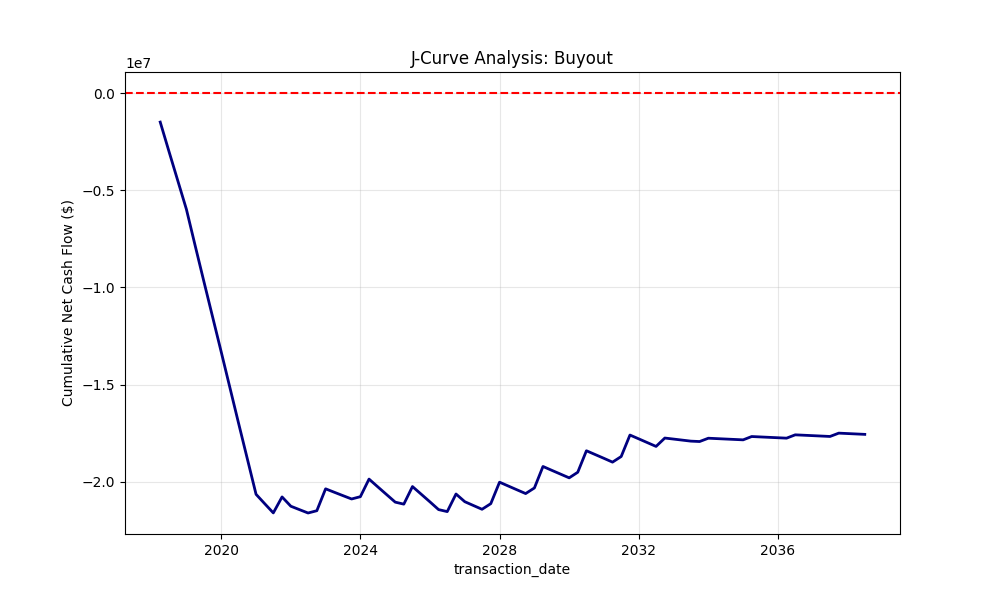

Graph displayed above. Saved to: j_curve_result.png
IRR: 0.43% (Periodic). J-Curve saved to j_curve_result.png.

The result for 'Buyout' shows an IRR of 0.43%. Let's check another strategy.

Action: IRR_JCurve_Tool
Action Input: Venture
[DEBUG] Filter: WHERE p.primary_strategy ILIKE '%%Venture%%' OR p.sub_strategy ILIKE '%%Venture%%'


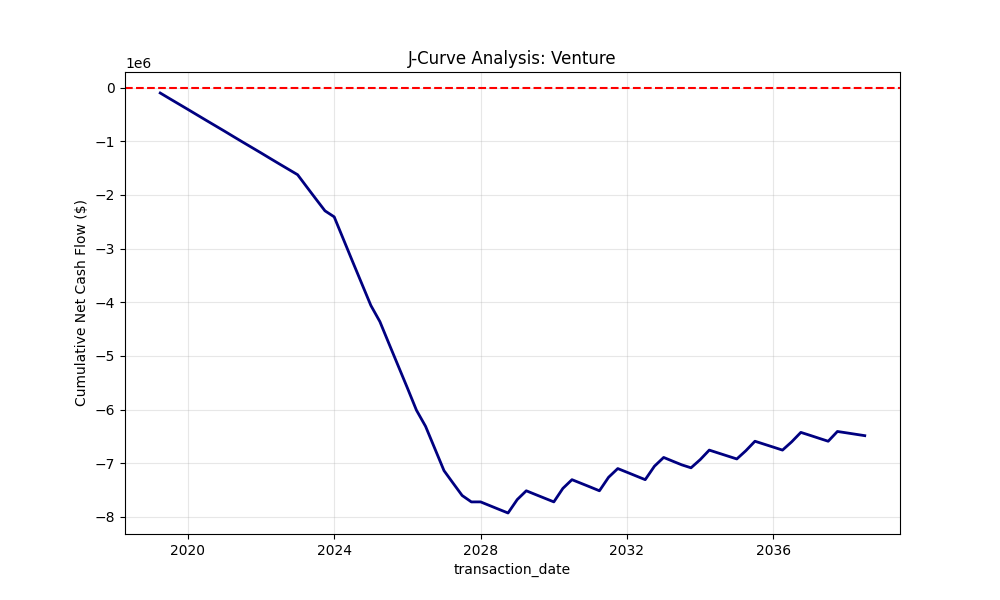

Graph displayed above. Saved to: j_curve_result.png
IRR: 0.84% (Periodic). J-Curve saved to j_curve_result.png.

The 'Venture' strategy has a higher IRR of 0.84% compared to 'Buyout's 0.43%. 

Final Answer: The primary strategy with the highest Internal Rate of Return (IRR) is Venture Capital, with an IRR of 0.84%.

> Finished chain.
Agent Answer: The primary strategy with the highest Internal Rate of Return (IRR) is Venture Capital, with an IRR of 0.84%.
--- Analyst Insight ---
**Analysis of Investment Strategy Performance**

The key takeaway from the data is that Venture Capital, with an IRR of 0.84%, is the highest-performing strategy among those considered. This figure is positive but notably low for a high-risk investment category like venture capital, which typically anticipates higher returns.

**Key Points:**
1. **IRR Performance**: The IRR of 0.84% indicates that while the strategy is profitable, it underperforms compared to typical expectations for venture capital investments

In [ ]:
import pandas as pd
import numpy_financial as npf
import matplotlib.pyplot as plt
import re
import sys
from sqlalchemy import create_engine, text

# --- COMPATIBILITY IMPORTS (Safe for OpenWebUI) ---
from langchain_community.llms import Ollama 
from langchain_community.utilities import SQLDatabase

# FIX: Robust imports for Tool and Agents
# Try standard locations first, then fallbacks
try:
    from langchain.agents import Tool, AgentExecutor, create_react_agent
except ImportError:
    try:
        # Newer LangChain structure
        from langchain_core.tools import Tool
        from langchain.agents import AgentExecutor, create_react_agent
    except ImportError:
        # Fallback for older/mixed environments
        from langchain.tools import Tool
        from langchain.agents import AgentExecutor, create_react_agent

from langchain import hub

# --- JUPYTER SUPPORT ---
try:
    from IPython.display import display, Image
    IN_JUPYTER = True
except ImportError:
    IN_JUPYTER = False

# --- 1. CONFIGURATION ---
DB_USER = "postgres"
DB_PASS = "postgres" 
DB_HOST = "127.0.0.1"
DB_PORT = "5432"
DB_NAME = "private_markets_db"

# DEEPSEEK CONFIG
LLM_MODEL = "deepseek-r1:70b"
LLM_BASE_URL = "http://localhost:21434"

# Connect to Database
try:
    connection_str = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(connection_str)
    db = SQLDatabase(engine)
    print(f"✅ Database Connected (User: {DB_USER})")
except Exception as e:
    print(f"❌ Database Error: {e}")
    sys.exit(1)

# --- 2. INITIALIZE LEGACY LLM ---
llm = Ollama(
    model=LLM_MODEL,
    base_url=LLM_BASE_URL,
    temperature=0.0,
    num_ctx=8192
)

# --- 3. ROBUST HELPER FUNCTIONS ---

def clean_llm_output(text: str) -> str:
    """
    Cleans DeepSeek-R1 output to prevent SQL Syntax Errors.
    Removes <think> tags and markdown code blocks.
    """
    if "</think>" in text:
        text = text.split("</think>")[-1]
    
    code_match = re.search(r"```sql\n(.*?)\n```", text, re.DOTALL)
    if code_match:
        return code_match.group(1).strip()
    
    code_match_generic = re.search(r"```\n(.*?)\n```", text, re.DOTALL)
    if code_match_generic:
        return code_match_generic.group(1).strip()
        
    text = text.replace("```sql", "").replace("```", "").strip()
    return text

# --- 4. TOOLS ---

def robust_sql_query(query_input: str):
    """
    Generates and executes SQL safely with strict logic for duplicates.
    """
    prompt = f"""
    You are a PostgreSQL expert. Given the user question, write a valid SQL query.
    
    ### DATABASE SCHEMA (STRICTLY FOLLOW THESE TABLE NAMES):
    1. Table: pe_portfolio (alias: p)
       - Columns: fund_id (PK), fund_name, vintage_year, 
                  primary_strategy (e.g., 'Private Equity', 'Venture Capital'), 
                  sub_strategy (e.g., 'Leveraged Buyout (LBO)', 'Growth Equity'), 
                  total_commitment_usd
    2. Table: pe_historical_cash_flows (alias: cf)
       - Columns: transaction_id, fund_id (FK), transaction_date, transaction_type, 
                  investment_paid_in_usd (negative), management_fees_usd (negative),
                  return_of_cost_distribution_usd (positive), profit_distribution_usd (positive),
                  net_asset_value_usd (NAV)

    ### CALCULATION RULES:
    1. Paid In = investment_paid_in_usd + management_fees_usd (Negative)
    2. Distributions = profit_distribution_usd + return_of_cost_distribution_usd (Positive)
    3. TVPI = (SUM(Distributions) + SUM(Latest_NAV)) / ABS(SUM(Paid_In))
    4. **MANAGEMENT FEES:** To find "Total Management Fees", SUM(management_fees_usd). The result will be negative; display as ABS().
    5. **LATEST NAV LOGIC (CRITICAL):**
       - Duplicate rows exist for the same date. Do NOT use a simple MAX(date).
       - Use this CTE pattern to pick the single latest row per fund:
         WITH ordered_navs AS (
             SELECT fund_id, net_asset_value_usd,
             ROW_NUMBER() OVER (PARTITION BY fund_id ORDER BY transaction_date DESC, transaction_id DESC) as rn
             FROM pe_historical_cash_flows
         )
         SELECT SUM(net_asset_value_usd) FROM ordered_navs WHERE rn = 1

    ### OUTPUT FORMAT:
    - Return ONLY the SQL code. No markdown, no explanations, no <think> tags.
    - If the user asks for a portfolio-wide metric (like "Total TVPI" or "Total Fees"), return a SINGLE row with a SINGLE column. Do NOT group by fund unless asked.
    
    Question: {query_input}
    """
    
    raw_response = llm.invoke(prompt)
    clean_sql = clean_llm_output(raw_response)
    
    print(f"\n[DEBUG] SQL Query:\n{clean_sql}\n")
    
    try:
        return db.run(clean_sql)
    except Exception as e:
        return f"SQL Execution Failed: {e}"

def calculate_irr_jcurve(filter_context: str = ""):
    """
    Calculates IRR and J-Curve.
    Input: A string describing the strategy/fund filter (e.g. "Buyout", "Fund V")
    """
    # --- SANITIZE INPUT ---
    # Remove quotes and standard SQL syntax to prevent double-quoting errors
    search_term = filter_context.strip().strip('"').strip("'")
    if search_term.lower().startswith("where "):
        search_term = search_term[6:]
    if search_term.lower().startswith("p."):
        search_term = search_term[2:]
    
    # Remove any internal quotes that might break SQL strings (e.g., 'Venture' -> Venture)
    search_term = search_term.replace("'", "").replace('"', "")
    
    # --- SMART FILTER LOGIC ---
    # Use ILIKE with wildcards for broad matching.
    where_clause = f"WHERE p.primary_strategy ILIKE '%%{search_term}%%' OR p.sub_strategy ILIKE '%%{search_term}%%'"
    
    print(f"[DEBUG] Filter: {where_clause}")

    sql = f"""
    SELECT 
        cf.transaction_date,
        (cf.investment_paid_in_usd + cf.management_fees_usd) as paid_in,
        (cf.return_of_cost_distribution_usd + cf.profit_distribution_usd) as distributions,
        cf.net_asset_value_usd,
        cf.fund_id
    FROM pe_historical_cash_flows cf
    JOIN pe_portfolio p ON cf.fund_id = p.fund_id
    {where_clause}
    ORDER BY cf.transaction_date
    """
    
    try:
        with engine.connect() as conn:
            df = pd.read_sql(text(sql), conn)
            
        if df.empty: return f"No data found matching '{search_term}'."

        # Net Cash Flow
        df['net_cf'] = df['paid_in'] + df['distributions']
        
        # Latest NAV Logic (Pandas Fallback for Accuracy)
        latest_nav = df.sort_values(['fund_id', 'transaction_date']).groupby('fund_id').tail(1)['net_asset_value_usd'].sum()
        
        # IRR Calculation
        timeline = df.groupby('transaction_date')['net_cf'].sum().sort_index()
        flows = timeline.tolist()
        if flows: flows[-1] += latest_nav
        
        try:
            irr = npf.irr(flows)
        except:
            irr = 0.0

        # J-Curve Plot
        cumulative_cf = timeline.cumsum()
        plt.figure(figsize=(10, 6))
        cumulative_cf.plot(title=f"J-Curve Analysis: {search_term}", color='navy', linewidth=2)
        plt.axhline(0, color='red', linestyle='--')
        plt.grid(True, alpha=0.3)
        plt.ylabel("Cumulative Net Cash Flow ($)")
        
        filename = "j_curve_result.png"
        plt.savefig(filename)
        plt.close()

        if IN_JUPYTER:
            try:
                display(Image(filename=filename))
                print(f"Graph displayed above. Saved to: {filename}")
            except Exception:
                pass

        return f"IRR: {irr:.2%} (Periodic). J-Curve saved to {filename}."
        
    except Exception as e:
        return f"Calculation Error: {e}"

def calculate_annual_cash_flows(filter_context: str = ""):
    """
    Aggregates Annual Net Cash Flows and Cumulative Cash Flows.
    Input: A keyword like "Private Equity" or "Buyout".
    """
    search_term = filter_context.strip().strip('"')
    search_term = search_term.replace("'", "").replace('"', "")
    
    where_clause = f"WHERE p.primary_strategy ILIKE '%%{search_term}%%' OR p.sub_strategy ILIKE '%%{search_term}%%'"
    
    sql = f"""
    SELECT 
        EXTRACT(YEAR FROM cf.transaction_date) as year,
        SUM(cf.investment_paid_in_usd + cf.management_fees_usd) as paid_in,
        SUM(cf.return_of_cost_distribution_usd + cf.profit_distribution_usd) as distributions
    FROM pe_historical_cash_flows cf
    JOIN pe_portfolio p ON cf.fund_id = p.fund_id
    {where_clause}
    GROUP BY 1
    ORDER BY 1
    """
    
    try:
        with engine.connect() as conn:
            df = pd.read_sql(text(sql), conn)
            
        if df.empty: return f"No data found matching '{search_term}'."
        
        df['net_cash_flow'] = df['paid_in'] + df['distributions']
        df['cumulative_net_cf'] = df['net_cash_flow'].cumsum()
        
        df['year'] = df['year'].astype(int)
        pd.options.display.float_format = '{:,.0f}'.format
        
        return f"Annual Cash Flows for {search_term}:\n" + df.to_string(index=False)
        
    except Exception as e:
        return f"Error: {e}"

def analyze_agent_output(input_text: str):
    """
    Analyzes the output from previous tools to provide summary or insights.
    Input: The raw output text from another tool (e.g. SQL results, IRR calculation).
    """
    prompt = f"""
    You are a Financial Analyst. Analyze the following data/result and provide a concise summary.
    
    DATA/RESULT:
    {input_text}
    
    YOUR ANALYSIS:
    - What is the key takeaway?
    - Are the numbers positive/negative?
    - Any trends?
    """
    
    # Direct invocation via legacy Ollama
    analysis = llm.invoke(prompt)
    clean_analysis = clean_llm_output(analysis)
    return clean_analysis

# --- 5. AGENT SETUP ---

def setup_agent():
    tools = [
        Tool(
            name="SQL_Query_Tool",
            func=robust_sql_query,
            description="Use for TVPI, MOIC, DPI, Distributions, Ranking. Input: Full user question."
        ),
        Tool(
            name="IRR_JCurve_Tool",
            func=calculate_irr_jcurve,
            description="Use for IRR/J-Curve. Input: A simple keyword like 'Buyout', 'Venture', or 'Fund V'.",
        ),
        Tool(
            name="Annual_Cash_Flow_Tool",
            func=calculate_annual_cash_flows,
            description="Use for Yearly/Annual cash flows. Input: A simple keyword like 'LBO' or 'Private Equity'."
        ),
        Tool(
            name="Analyze_Output_Tool",
            func=analyze_agent_output,
            description="Use this to analyze the result of a calculation or query. Input: The text output from another tool."
        )
    ]
    
    prompt = hub.pull("hwchase17/react")
    agent = create_react_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

# --- 6. BATCH EXECUTION ---
if __name__ == "__main__":
    agent = setup_agent()
    print("\n" + "="*50)
    print("🤖 Private Equity Agent Ready")
    print("   - Connected to DeepSeek-R1 (Port 21434)")
    print("   - Connected to Postgres (Port 5432)")
    print("   - Executing Batch Test Plan...")
    print("="*50 + "\n")
    
    test_questions = [
        "What is the TVPI and DPI of the entire portfolio?",
        "Which primary strategy has the highest Internal Rate of Return (IRR)?",
        "What is the total Paid-In capital for the 'Growth Equity' sub-strategy?",
        "Which specific fund has distributed the most capital to date?",
        "Show me the J-Curve for the 'Private Equity' strategy.",
        "What are the yearly net cash flows for the 'Venture Capital' strategy?",
        "What is the total remaining commitment (uncalled capital) for the 'Real Estate' strategy?",
        "What is the TVPI for 'Infrastructure' funds with a vintage year of 2018 or later?",
        "What is the total amount of management fees paid across the entire portfolio?",
        "Calculate the IRR for Buyout funds."
    ]
    
    for i, q in enumerate(test_questions, 1):
        print(f"\n🔹 Question {i}: {q}")
        try:
            result = agent.invoke({"input": q})
            print(f"Agent Answer: {result['output']}")
            
            # Auto-Analyze the answer
            print("--- Analyst Insight ---")
            analysis = analyze_agent_output(result['output'])
            print(f"{analysis}\n")
            
        except Exception as e:
            print(f"❌ Error: {e}\n")